In [1]:
import pandas as pd
import pmdarima as pm

import os.path
from os import path
import numpy as np
import pickle
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
%matplotlib inline

/Users/bethanys08/.pyenv/versions/anaconda3-2019.03/envs/myenv2/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/Users/bethanys08/.pyenv/versions/anaconda3-2019.03/envs/myenv2/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
/Users/bethanys08/.pyenv/versions/anaconda3-2019.03/envs/myenv2/lib/python3.7/site-packages/lightgb

In [2]:
def smape_error(forecast, actual):
    numerator = np.absolute(forecast-actual)
    denominator = np.absolute(forecast) + np.absolute(actual)

    num_samples = len(numerator)

    return 100/num_samples * np.sum(numerator/denominator)

In [3]:
df = pd.read_pickle('1.collect_data/data_files/1hr.pkl').replace([np.inf, -np.inf], np.nan).dropna()
df.reset_index(inplace=True)

blockface_detail = pd.read_csv('1.collect_data/blockface_detail.csv')

In [4]:
# load weather
weather = pd.read_pickle('1.collect_data/data_files/weather/2010-2019_daily_weather.pkl')
weather = weather[weather.index > '2019-01-01'].resample('H').ffill()
weather.head()

,PRCP,SNOW,TAVG,TMAX,TMIN
DATE,,,,,
2019-01-02 00:00:00,0.01,0.0,40.0,47.0,33.0
2019-01-02 01:00:00,0.01,0.0,40.0,47.0,33.0
2019-01-02 02:00:00,0.01,0.0,40.0,47.0,33.0
2019-01-02 03:00:00,0.01,0.0,40.0,47.0,33.0
2019-01-02 04:00:00,0.01,0.0,40.0,47.0,33.0


In [5]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose':-1, 
}

In [6]:
df.head()

,SourceElementKey,OccupancyDateTime,PaidOccupancy,ParkingSpaceCount,PercentOccupied
0,1001,2012-01-03 09:00:00,0.983333,7.0,0.140476
1,1001,2012-01-03 10:00:00,2.016667,7.0,0.288095
2,1001,2012-01-03 11:00:00,4.633333,7.0,0.661905
3,1001,2012-01-03 12:00:00,3.283333,7.0,0.469048
4,1001,2012-01-03 13:00:00,1.116667,7.0,0.159524


In [7]:
start_date = '2019-01-01'

df_2019 = df[df['OccupancyDateTime'] > (start_date)]
df_2019

,SourceElementKey,OccupancyDateTime,PaidOccupancy,ParkingSpaceCount,PercentOccupied
21190,1001,2019-01-02 09:00:00,0.000000,6.0,0.000000
21191,1001,2019-01-02 10:00:00,0.000000,6.0,0.000000
21192,1001,2019-01-02 11:00:00,0.666667,6.0,0.111111
21193,1001,2019-01-02 12:00:00,2.133333,6.0,0.355556
21194,1001,2019-01-02 13:00:00,1.783333,6.0,0.297222
...,...,...,...,...,...
38586661,121340,2019-08-30 13:00:00,1.100000,2.0,0.550000
38586662,121340,2019-08-30 14:00:00,0.916667,2.0,0.458333
38586663,121340,2019-08-30 15:00:00,0.633333,2.0,0.316667
38586664,121340,2019-08-30 16:00:00,0.000000,2.0,0.000000


In [8]:
block_dfs = []


#block = 1001

for block in blockface_detail.sourceelementkey.values[:100]:
    block_file = 'arima_results2/arima.%d.pkl' % block
    if path.exists(block_file):

        # select only data for block, timeframe
        mask = (df_2019['SourceElementKey'] == block) 
        curr = df_2019[mask].set_index('OccupancyDateTime')

        # find number of time chunks per day
        time_chunks_per_day = curr.groupby(curr.index.dayofyear).count().SourceElementKey.max()


        pct_occupied = curr.PercentOccupied

        num_split = int(.7*len(pct_occupied))

        train, test = pct_occupied.iloc[:num_split], pct_occupied.iloc[num_split:]
        df_train, df_test = curr.iloc[:num_split], curr.iloc[num_split:]

        # Load model and predict on test set
        pkl = open(block_file, 'rb')
        mdl = pickle.load(pkl)


        #break

        in_sample_preds = mdl.predict_in_sample()
        test_preds = mdl.predict(n_periods=test.shape[0])

        all_preds = np.concatenate((in_sample_preds, test_preds), axis=0)
        all_resids = curr.PercentOccupied - all_preds
        curr['Residuals_pct_occupied_sarima'] =  all_resids
        curr['SARIMA_Preds'] = all_preds

        
        block_dfs.append(pd.merge(curr, weather, left_index=True, right_index=True))





In [9]:
last_year = pd.concat(block_dfs)
last_year.index.name='OccupancyDateTime'

In [10]:
merged = pd.merge(last_year.reset_index(), 
                  blockface_detail, 
                  how='left', 
                  left_on='SourceElementKey', 
                  right_on='sourceelementkey').drop(['sourceelementkey', 
                                                     'location', 
                                                     'parkingcategory', 
                                                     'Unnamed: 0', 
                                                     'parkingtimelimitcategory'], axis=1)

In [11]:
merged

,OccupancyDateTime,SourceElementKey,PaidOccupancy,ParkingSpaceCount,PercentOccupied,Residuals_pct_occupied_sarima,SARIMA_Preds,PRCP,SNOW,TAVG,TMAX,TMIN,blockfacename,paidparkingarea,paidparkingsubarea,parkingspacecount,sideofstreet,latitude,longitude
0,2019-01-02 09:00:00,1001,0.000000,6.0,0.000000,-0.283089,0.283089,0.01,0.0,40.0,47.0,33.0,1ST AVE BETWEEN CHERRY ST AND COLUMBIA ST,Pioneer Square,Core,4,SW,47.602873,-122.334694
1,2019-01-02 10:00:00,1001,0.000000,6.0,0.000000,-0.118188,0.118188,0.01,0.0,40.0,47.0,33.0,1ST AVE BETWEEN CHERRY ST AND COLUMBIA ST,Pioneer Square,Core,4,SW,47.602873,-122.334694
2,2019-01-02 11:00:00,1001,0.666667,6.0,0.111111,-0.026895,0.138006,0.01,0.0,40.0,47.0,33.0,1ST AVE BETWEEN CHERRY ST AND COLUMBIA ST,Pioneer Square,Core,4,SW,47.602873,-122.334694
3,2019-01-02 12:00:00,1001,2.133333,6.0,0.355556,0.147407,0.208148,0.01,0.0,40.0,47.0,33.0,1ST AVE BETWEEN CHERRY ST AND COLUMBIA ST,Pioneer Square,Core,4,SW,47.602873,-122.334694
4,2019-01-02 13:00:00,1001,1.783333,6.0,0.297222,-0.065029,0.362252,0.01,0.0,40.0,47.0,33.0,1ST AVE BETWEEN CHERRY ST AND COLUMBIA ST,Pioneer Square,Core,4,SW,47.602873,-122.334694
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234488,2019-08-31 15:00:00,8306,3.100000,8.0,0.387500,0.059450,0.328050,0.00,0.0,70.5,80.0,61.0,7TH AVE S BETWEEN S WELLER ST AND S LANE ST,Chinatown/ID,Core,8,E,47.597087,-122.323637
234489,2019-08-31 16:00:00,8306,4.100000,8.0,0.512500,0.221556,0.290944,0.00,0.0,70.5,80.0,61.0,7TH AVE S BETWEEN S WELLER ST AND S LANE ST,Chinatown/ID,Core,8,E,47.597087,-122.323637
234490,2019-08-31 17:00:00,8306,5.633333,8.0,0.704167,0.363937,0.340230,0.00,0.0,70.5,80.0,61.0,7TH AVE S BETWEEN S WELLER ST AND S LANE ST,Chinatown/ID,Core,8,E,47.597087,-122.323637
234491,2019-08-31 18:00:00,8306,6.983333,8.0,0.872917,0.425735,0.447181,0.00,0.0,70.5,80.0,61.0,7TH AVE S BETWEEN S WELLER ST AND S LANE ST,Chinatown/ID,Core,8,E,47.597087,-122.323637


In [12]:
merged['Month'] = merged.OccupancyDateTime.dt.month
merged['Year'] = merged.OccupancyDateTime.dt.year
merged['Hour'] = merged.OccupancyDateTime.dt.hour
merged['DayOfWeek'] = merged.OccupancyDateTime.dt.dayofweek
merged['Day'] = merged.OccupancyDateTime.dt.day
merged['IsWeekend'] = (merged.OccupancyDateTime.dt.dayofweek >= 5)

In [13]:
merged

,OccupancyDateTime,SourceElementKey,PaidOccupancy,ParkingSpaceCount,PercentOccupied,Residuals_pct_occupied_sarima,SARIMA_Preds,PRCP,SNOW,TAVG,...,parkingspacecount,sideofstreet,latitude,longitude,Month,Year,Hour,DayOfWeek,Day,IsWeekend
0,2019-01-02 09:00:00,1001,0.000000,6.0,0.000000,-0.283089,0.283089,0.01,0.0,40.0,...,4,SW,47.602873,-122.334694,1,2019,9,2,2,False
1,2019-01-02 10:00:00,1001,0.000000,6.0,0.000000,-0.118188,0.118188,0.01,0.0,40.0,...,4,SW,47.602873,-122.334694,1,2019,10,2,2,False
2,2019-01-02 11:00:00,1001,0.666667,6.0,0.111111,-0.026895,0.138006,0.01,0.0,40.0,...,4,SW,47.602873,-122.334694,1,2019,11,2,2,False
3,2019-01-02 12:00:00,1001,2.133333,6.0,0.355556,0.147407,0.208148,0.01,0.0,40.0,...,4,SW,47.602873,-122.334694,1,2019,12,2,2,False
4,2019-01-02 13:00:00,1001,1.783333,6.0,0.297222,-0.065029,0.362252,0.01,0.0,40.0,...,4,SW,47.602873,-122.334694,1,2019,13,2,2,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234488,2019-08-31 15:00:00,8306,3.100000,8.0,0.387500,0.059450,0.328050,0.00,0.0,70.5,...,8,E,47.597087,-122.323637,8,2019,15,5,31,True
234489,2019-08-31 16:00:00,8306,4.100000,8.0,0.512500,0.221556,0.290944,0.00,0.0,70.5,...,8,E,47.597087,-122.323637,8,2019,16,5,31,True
234490,2019-08-31 17:00:00,8306,5.633333,8.0,0.704167,0.363937,0.340230,0.00,0.0,70.5,...,8,E,47.597087,-122.323637,8,2019,17,5,31,True
234491,2019-08-31 18:00:00,8306,6.983333,8.0,0.872917,0.425735,0.447181,0.00,0.0,70.5,...,8,E,47.597087,-122.323637,8,2019,18,5,31,True


In [14]:
merged.paidparkingarea.unique()

array(['Pioneer Square', 'Commercial Core', 'Belltown', 'Uptown',
       'Pike-Pine', 'University District', '12th Avenue', 'Capitol Hill',
       'Roosevelt', 'Ballard', 'Columbia City', 'Chinatown/ID',
       'Denny Triangle', 'First Hill'], dtype=object)

In [15]:
for col in ['SourceElementKey', 'DayOfWeek', 'Hour', 'paidparkingarea']:
    merged[col] = merged[col].astype('category')

In [16]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 234493 entries, 0 to 234492
Data columns (total 25 columns):
OccupancyDateTime                234493 non-null datetime64[ns]
SourceElementKey                 234493 non-null category
PaidOccupancy                    234493 non-null float64
ParkingSpaceCount                234493 non-null float64
PercentOccupied                  234493 non-null float64
Residuals_pct_occupied_sarima    234493 non-null float64
SARIMA_Preds                     234493 non-null float64
PRCP                             234493 non-null float64
SNOW                             234493 non-null float64
TAVG                             234493 non-null float64
TMAX                             234493 non-null float64
TMIN                             234493 non-null float64
blockfacename                    234493 non-null object
paidparkingarea                  234493 non-null category
paidparkingsubarea               205525 non-null object
parkingspacecount          

In [17]:
test_date = '2019-06-20'

mask = merged['OccupancyDateTime'] > (test_date)
df_train = merged[~mask]
df_test = merged[mask]

In [18]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 165013 entries, 0 to 233748
Data columns (total 25 columns):
OccupancyDateTime                165013 non-null datetime64[ns]
SourceElementKey                 165013 non-null category
PaidOccupancy                    165013 non-null float64
ParkingSpaceCount                165013 non-null float64
PercentOccupied                  165013 non-null float64
Residuals_pct_occupied_sarima    165013 non-null float64
SARIMA_Preds                     165013 non-null float64
PRCP                             165013 non-null float64
SNOW                             165013 non-null float64
TAVG                             165013 non-null float64
TMAX                             165013 non-null float64
TMIN                             165013 non-null float64
blockfacename                    165013 non-null object
paidparkingarea                  165013 non-null category
paidparkingsubarea               144849 non-null object
parkingspacecount          

In [19]:
rf_columns = ['SourceElementKey', 'Month', 'DayOfWeek', 
              'latitude', 'longitude', 'IsWeekend', 
              'paidparkingarea', 'Hour', 'Day',
              'PRCP',  'SNOW',  'TAVG',  
             ]

In [20]:
rf_train = lgb.Dataset(data=df_train[rf_columns], 
                           label=df_train['Residuals_pct_occupied_sarima'],
                            feature_name=rf_columns)
rf_test = lgb.Dataset(data=df_test[rf_columns], 
                          label=df_test['Residuals_pct_occupied_sarima'], 
                          feature_name=rf_columns,
                          reference=rf_train)

In [21]:
params = {
    'boosting_type': 'rf',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'num_leaves': 40,
    'learning_rate': 0.01,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'num_threads':6,
    'n_iter':1000,
    
}

In [22]:
print('Starting training...')
# train
gbm_rf = lgb.train(params,
                rf_train,
                valid_sets=rf_test)

print('Saving model...')
# save model to file
gbm_rf.save_model('lightgbm_models/sarima_rf_model.txt')

Starting training...


/Users/bethanys08/.pyenv/versions/anaconda3-2019.03/envs/myenv2/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `n_iter` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/bethanys08/.pyenv/versions/anaconda3-2019.03/envs/myenv2/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[1]	valid_0's l1: 0.165322	valid_0's l2: 0.0510298
[2]	valid_0's l1: 0.164833	valid_0's l2: 0.0508591
[3]	valid_0's l1: 0.16494	valid_0's l2: 0.0508976
[4]	valid_0's l1: 0.165106	valid_0's l2: 0.0509441
[5]	valid_0's l1: 0.165147	valid_0's l2: 0.050948
[6]	valid_0's l1: 0.165137	valid_0's l2: 0.0509095
[7]	valid_0's l1: 0.165132	valid_0's l2: 0.0508942
[8]	valid_0's l1: 0.16515	valid_0's l2: 0.0508725
[9]	valid_0's l1: 0.165253	valid_0's l2: 0.050926
[10]	valid_0's l1: 0.165201	valid_0's l2: 0.0509039
[11]	valid_0's l1: 0.165286	valid_0's l2: 0.0509494
[12]	valid_0's l1: 0.165228	valid_0's l2: 0.0509502
[13]	valid_0's l1: 0.165229	valid_0's l2: 0.0509516
[14]	valid_0's l1: 0.165203	valid_0's l2: 0.0509533
[15]	valid_0's l1: 0.165211	valid_0's l2: 0.0509624
[16]	valid_0's l1: 0.165214	valid_0's l2: 0.0509612
[17]	valid_0's l1: 0.165214	valid_0's l2: 0.0509572
[18]	valid_0's l1: 0.165219	valid_0's l2: 0.0509556
[19]	valid_0's l1: 0.165195	valid_0's l2: 0.0509488
[20]	valid_0's l1: 0.1652

[164]	valid_0's l1: 0.165084	valid_0's l2: 0.050875
[165]	valid_0's l1: 0.165083	valid_0's l2: 0.0508747
[166]	valid_0's l1: 0.165081	valid_0's l2: 0.0508739
[167]	valid_0's l1: 0.165077	valid_0's l2: 0.0508739
[168]	valid_0's l1: 0.165077	valid_0's l2: 0.0508731
[169]	valid_0's l1: 0.165076	valid_0's l2: 0.0508721
[170]	valid_0's l1: 0.165073	valid_0's l2: 0.0508706
[171]	valid_0's l1: 0.165071	valid_0's l2: 0.0508699
[172]	valid_0's l1: 0.16507	valid_0's l2: 0.0508693
[173]	valid_0's l1: 0.165069	valid_0's l2: 0.0508689
[174]	valid_0's l1: 0.165069	valid_0's l2: 0.0508685
[175]	valid_0's l1: 0.16507	valid_0's l2: 0.0508682
[176]	valid_0's l1: 0.16507	valid_0's l2: 0.0508675
[177]	valid_0's l1: 0.165068	valid_0's l2: 0.0508666
[178]	valid_0's l1: 0.165072	valid_0's l2: 0.0508684
[179]	valid_0's l1: 0.165071	valid_0's l2: 0.0508675
[180]	valid_0's l1: 0.165069	valid_0's l2: 0.0508667
[181]	valid_0's l1: 0.165074	valid_0's l2: 0.0508692
[182]	valid_0's l1: 0.165073	valid_0's l2: 0.05086

[337]	valid_0's l1: 0.165073	valid_0's l2: 0.050868
[338]	valid_0's l1: 0.165074	valid_0's l2: 0.0508683
[339]	valid_0's l1: 0.165074	valid_0's l2: 0.0508685
[340]	valid_0's l1: 0.165072	valid_0's l2: 0.0508678
[341]	valid_0's l1: 0.165071	valid_0's l2: 0.0508673
[342]	valid_0's l1: 0.165073	valid_0's l2: 0.0508679
[343]	valid_0's l1: 0.165073	valid_0's l2: 0.0508678
[344]	valid_0's l1: 0.165072	valid_0's l2: 0.0508673
[345]	valid_0's l1: 0.16507	valid_0's l2: 0.0508668
[346]	valid_0's l1: 0.165072	valid_0's l2: 0.0508678
[347]	valid_0's l1: 0.165072	valid_0's l2: 0.0508673
[348]	valid_0's l1: 0.165072	valid_0's l2: 0.050867
[349]	valid_0's l1: 0.165071	valid_0's l2: 0.0508665
[350]	valid_0's l1: 0.165071	valid_0's l2: 0.050866
[351]	valid_0's l1: 0.165069	valid_0's l2: 0.0508655
[352]	valid_0's l1: 0.165069	valid_0's l2: 0.0508654
[353]	valid_0's l1: 0.165069	valid_0's l2: 0.0508657
[354]	valid_0's l1: 0.165072	valid_0's l2: 0.0508672
[355]	valid_0's l1: 0.165073	valid_0's l2: 0.05086

[493]	valid_0's l1: 0.16508	valid_0's l2: 0.0508676
[494]	valid_0's l1: 0.165079	valid_0's l2: 0.0508674
[495]	valid_0's l1: 0.16508	valid_0's l2: 0.0508677
[496]	valid_0's l1: 0.16508	valid_0's l2: 0.0508679
[497]	valid_0's l1: 0.165083	valid_0's l2: 0.050869
[498]	valid_0's l1: 0.165083	valid_0's l2: 0.0508692
[499]	valid_0's l1: 0.165084	valid_0's l2: 0.0508694
[500]	valid_0's l1: 0.165085	valid_0's l2: 0.0508696
[501]	valid_0's l1: 0.165084	valid_0's l2: 0.0508695
[502]	valid_0's l1: 0.165086	valid_0's l2: 0.0508702
[503]	valid_0's l1: 0.165085	valid_0's l2: 0.0508701
[504]	valid_0's l1: 0.165084	valid_0's l2: 0.0508697
[505]	valid_0's l1: 0.165086	valid_0's l2: 0.0508708
[506]	valid_0's l1: 0.165087	valid_0's l2: 0.0508707
[507]	valid_0's l1: 0.165086	valid_0's l2: 0.0508706
[508]	valid_0's l1: 0.165086	valid_0's l2: 0.0508706
[509]	valid_0's l1: 0.165086	valid_0's l2: 0.0508705
[510]	valid_0's l1: 0.165085	valid_0's l2: 0.0508704
[511]	valid_0's l1: 0.165086	valid_0's l2: 0.05087

[651]	valid_0's l1: 0.165083	valid_0's l2: 0.0508679
[652]	valid_0's l1: 0.165083	valid_0's l2: 0.0508678
[653]	valid_0's l1: 0.165083	valid_0's l2: 0.0508678
[654]	valid_0's l1: 0.165085	valid_0's l2: 0.0508684
[655]	valid_0's l1: 0.165085	valid_0's l2: 0.0508684
[656]	valid_0's l1: 0.165085	valid_0's l2: 0.0508682
[657]	valid_0's l1: 0.165084	valid_0's l2: 0.050868
[658]	valid_0's l1: 0.165084	valid_0's l2: 0.0508679
[659]	valid_0's l1: 0.165084	valid_0's l2: 0.0508679
[660]	valid_0's l1: 0.165084	valid_0's l2: 0.0508676
[661]	valid_0's l1: 0.165084	valid_0's l2: 0.0508676
[662]	valid_0's l1: 0.165084	valid_0's l2: 0.0508674
[663]	valid_0's l1: 0.165084	valid_0's l2: 0.0508674
[664]	valid_0's l1: 0.165085	valid_0's l2: 0.0508677
[665]	valid_0's l1: 0.165085	valid_0's l2: 0.0508677
[666]	valid_0's l1: 0.165084	valid_0's l2: 0.0508671
[667]	valid_0's l1: 0.165084	valid_0's l2: 0.050867
[668]	valid_0's l1: 0.165083	valid_0's l2: 0.0508667
[669]	valid_0's l1: 0.165082	valid_0's l2: 0.050

[809]	valid_0's l1: 0.16508	valid_0's l2: 0.0508638
[810]	valid_0's l1: 0.16508	valid_0's l2: 0.0508637
[811]	valid_0's l1: 0.165082	valid_0's l2: 0.0508643
[812]	valid_0's l1: 0.16508	valid_0's l2: 0.0508638
[813]	valid_0's l1: 0.16508	valid_0's l2: 0.0508637
[814]	valid_0's l1: 0.165079	valid_0's l2: 0.0508632
[815]	valid_0's l1: 0.165079	valid_0's l2: 0.0508629
[816]	valid_0's l1: 0.165078	valid_0's l2: 0.0508627
[817]	valid_0's l1: 0.165078	valid_0's l2: 0.0508627
[818]	valid_0's l1: 0.165079	valid_0's l2: 0.0508629
[819]	valid_0's l1: 0.165078	valid_0's l2: 0.0508627
[820]	valid_0's l1: 0.165078	valid_0's l2: 0.0508625
[821]	valid_0's l1: 0.165078	valid_0's l2: 0.0508625
[822]	valid_0's l1: 0.165077	valid_0's l2: 0.0508623
[823]	valid_0's l1: 0.165077	valid_0's l2: 0.0508624
[824]	valid_0's l1: 0.165077	valid_0's l2: 0.0508624
[825]	valid_0's l1: 0.165077	valid_0's l2: 0.0508623
[826]	valid_0's l1: 0.165078	valid_0's l2: 0.0508626
[827]	valid_0's l1: 0.165078	valid_0's l2: 0.05086

[979]	valid_0's l1: 0.165082	valid_0's l2: 0.0508651
[980]	valid_0's l1: 0.165083	valid_0's l2: 0.0508656
[981]	valid_0's l1: 0.165083	valid_0's l2: 0.0508656
[982]	valid_0's l1: 0.165083	valid_0's l2: 0.0508655
[983]	valid_0's l1: 0.165083	valid_0's l2: 0.0508655
[984]	valid_0's l1: 0.165083	valid_0's l2: 0.0508654
[985]	valid_0's l1: 0.165084	valid_0's l2: 0.0508657
[986]	valid_0's l1: 0.165084	valid_0's l2: 0.0508656
[987]	valid_0's l1: 0.165083	valid_0's l2: 0.0508653
[988]	valid_0's l1: 0.165082	valid_0's l2: 0.0508651
[989]	valid_0's l1: 0.165082	valid_0's l2: 0.0508652
[990]	valid_0's l1: 0.165082	valid_0's l2: 0.050865
[991]	valid_0's l1: 0.165081	valid_0's l2: 0.0508649
[992]	valid_0's l1: 0.165081	valid_0's l2: 0.0508647
[993]	valid_0's l1: 0.165081	valid_0's l2: 0.0508646
[994]	valid_0's l1: 0.16508	valid_0's l2: 0.0508644
[995]	valid_0's l1: 0.16508	valid_0's l2: 0.0508645
[996]	valid_0's l1: 0.165079	valid_0's l2: 0.0508643
[997]	valid_0's l1: 0.165079	valid_0's l2: 0.0508

In [23]:
y_pred = gbm_rf.predict(merged[rf_columns], num_iteration=gbm_rf.best_iteration)

In [24]:
merged['RF_results'] = y_pred
merged['SARIMA_Plus_RF'] = merged['RF_results'] + merged['SARIMA_Preds']

In [25]:
block = 1001

mask = (merged['SourceElementKey'] == block) & (merged['OccupancyDateTime'] > (test_date))
curr = merged[mask]


In [26]:
curr[['OccupancyDateTime', 'RF_results', 'SARIMA_Preds', 'SARIMA_Plus_RF', 'PercentOccupied']]

,OccupancyDateTime,RF_results,SARIMA_Preds,SARIMA_Plus_RF,PercentOccupied
1419,2019-06-20 08:00:00,-0.014569,0.122758,0.108189,0.097043
1420,2019-06-20 09:00:00,0.022125,0.138143,0.160268,0.050000
1421,2019-06-20 10:00:00,0.029592,0.386654,0.416246,0.216667
1422,2019-06-20 11:00:00,0.025198,0.350114,0.375312,0.529167
1423,2019-06-20 12:00:00,0.018287,0.609321,0.627608,0.620833
...,...,...,...,...,...
2034,2019-08-31 13:00:00,-0.037818,0.452743,0.414924,0.250000
2035,2019-08-31 14:00:00,0.012248,0.280756,0.293004,0.283333
2036,2019-08-31 15:00:00,0.012248,0.296082,0.308330,0.141667
2037,2019-08-31 16:00:00,0.002765,0.245220,0.247985,0.420833


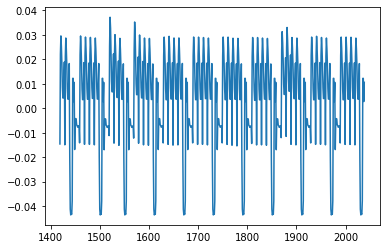

In [27]:
plt.figure()
plt.plot(curr.RF_results)
#plt.plot(curr.Residuals_pct_occupied_sarima)
plt.show()

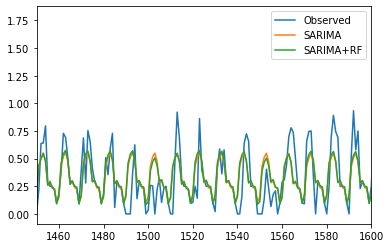

In [28]:
fig, ax = plt.subplots()
ax.plot(curr['PercentOccupied'], label='Observed')

ax.plot(curr['SARIMA_Preds'], label='SARIMA')
ax.plot(curr['SARIMA_Plus_RF'], label='SARIMA+RF')
ax.legend()
ax.set_xlim(1450,1600)
plt.show()

In [29]:
arima2_results = pd.read_pickle('arima_results2/arima_results.pkl')
arima2_results.head()

,ArimaSmapeErrors,GBMSmapeErrors,TrainingSetLength,ArimaRMSEs,ModelOrder,TestVals,ArimaPreds,GBMPreds,SurroundsTest,NonSeasonal,Seasonal,p,d,q,P,D,Q,m
SourceElementKey,,,,,,,,,,,,,,,,,,
1001,26.778236,34.434702,1427,0.225284,"((0, 0, 3), (4, 0, 4, 10))",OccupancyDateTime 2019-06-20 16:00:00 0.247...,"[0.30421134507792436, 0.22696330244619553, 0.1...","[0.29248498129242667, 0.29248498129242667, 0.2...",OccupancyDateTime 2019-06-20 17:00:00 0.389...,"(0, 0, 3)","(4, 0, 4, 10)",0,0,3,4,0,4,10
1002,25.950885,37.279208,1427,0.183905,"((2, 0, 2), (2, 0, 2, 10))",OccupancyDateTime 2019-06-20 16:00:00 0.237...,"[0.254857374389947, 0.2777993535872891, 0.0301...","[0.27232191637687037, 0.27232191637687037, 0.2...",OccupancyDateTime 2019-06-20 17:00:00 0.371...,"(2, 0, 2)","(2, 0, 2, 10)",2,0,2,2,0,2,10
1006,24.222940,33.132488,1696,0.171301,"((4, 0, 2), (4, 0, 4, 12))",OccupancyDateTime 2019-06-21 13:00:00 0.507...,"[0.5059965728826651, 0.35324215008701726, 0.25...","[0.3211730913292586, 0.3211730913292586, 0.321...",OccupancyDateTime 2019-06-21 14:00:00 0.350...,"(4, 0, 2)","(4, 0, 4, 12)",4,0,2,4,0,4,12
1009,29.071818,38.520762,1712,0.162182,"((1, 0, 2), (4, 0, 4, 12))",OccupancyDateTime 2019-06-20 17:00:00 0.436...,"[0.4442358711245875, 0.39905134806806686, 0.13...","[0.29087346552916865, 0.29087346552916865, 0.2...",OccupancyDateTime 2019-06-20 18:00:00 0.547...,"(1, 0, 2)","(4, 0, 4, 12)",1,0,2,4,0,4,12
1010,16.606980,24.154482,1712,0.203732,"((2, 0, 3), (2, 0, 3, 12))",OccupancyDateTime 2019-06-20 17:00:00 0.620...,"[0.6311579389046404, 0.5975534116314929, 0.363...","[0.5597597884610469, 0.5597597884610469, 0.559...",OccupancyDateTime 2019-06-20 18:00:00 0.488...,"(2, 0, 3)","(2, 0, 3, 12)",2,0,3,2,0,3,12


In [30]:
arima2_results['ArimaPlusRFSmapeErrors'] = np.nan
for block in arima2_results.index.values:
    mask = (merged['SourceElementKey'] == block) & (merged['OccupancyDateTime'] > (test_date))
    curr = merged[mask]
    if len(curr.SARIMA_Plus_RF) > 0:
    
        arima_rf_smape = smape_error(curr.SARIMA_Plus_RF, curr.PercentOccupied)
        arima2_results.at[block, 'ArimaPlusRFSmapeErrors'] = arima_rf_smape
    else:
        print(block)
        #print(arima_rf_smape, arima2_results.loc[block].ArimaSmapeErrors, arima2_results.loc[block].GBMSmapeErrors)

1037
1041
1045
6166
7246


In [31]:
arima2_results[['ArimaPlusRFSmapeErrors', 'ArimaSmapeErrors', 'GBMSmapeErrors']].dropna(axis=0).mean()

ArimaPlusRFSmapeErrors    24.945457
ArimaSmapeErrors          25.022231
GBMSmapeErrors            28.542260
dtype: float64

# Arima Results 3 (averaged with 1 block radius)

In [32]:
df = pd.read_pickle('1.collect_data/data_files/1hr_1block-average.pkl').replace([np.inf, -np.inf], np.nan).dropna()
df.reset_index(inplace=True)

In [33]:
start_date = '2019-01-01'

df_2019 = df[df['OccupancyDateTime'] > (start_date)]
df_2019

,SourceElementKey,OccupancyDateTime,PaidOccupancy,ParkingSpaceCount,PercentOccupied
25152,1001,2019-01-02 08:00:00,10.266667,45.0,0.228148
25153,1001,2019-01-02 09:00:00,13.116667,65.0,0.201795
25154,1001,2019-01-02 10:00:00,17.666667,65.0,0.271795
25155,1001,2019-01-02 11:00:00,18.433333,65.0,0.283590
25156,1001,2019-01-02 12:00:00,17.116667,65.0,0.263333
...,...,...,...,...,...
38659628,136322,2019-08-31 15:00:00,4.850000,26.0,0.186538
38659629,136322,2019-08-31 16:00:00,3.850000,26.0,0.148077
38659630,136322,2019-08-31 17:00:00,2.283333,26.0,0.087821
38659631,136322,2019-08-31 18:00:00,3.316667,26.0,0.127564


In [34]:
block_dfs = []


#block = 1001

for block in blockface_detail.sourceelementkey.values[:100]:
    block_file = 'arima_results3/arima.%d.pkl' % block
    if path.exists(block_file):

        # select only data for block, timeframe
        mask = (df_2019['SourceElementKey'] == block) 
        curr = df_2019[mask].set_index('OccupancyDateTime')

        # find number of time chunks per day
        time_chunks_per_day = curr.groupby(curr.index.dayofyear).count().SourceElementKey.max()


        pct_occupied = curr.PercentOccupied

        num_split = int(.7*len(pct_occupied))
        oob_length = int(0.2*len(pct_occupied))

        train, test = pct_occupied.iloc[:num_split], pct_occupied.iloc[num_split:]
        df_train, df_test = curr.iloc[:num_split], curr.iloc[num_split:]

        # Load model and predict on test set
        pkl = open(block_file, 'rb')
        mdl = pickle.load(pkl)


        #break

        in_sample_preds = mdl.predict_in_sample()
        
        test_preds = mdl.predict(n_periods=test.shape[0])
        #print(block, len(in_sample_preds), len(test_preds), len(pct_occupied), num_split, len(test))

        all_preds = np.concatenate((in_sample_preds, test_preds), axis=0)
        all_resids = curr.PercentOccupied - all_preds
        curr['Residuals_pct_occupied_sarima'] =  all_resids
        curr['SARIMA_Preds'] = all_preds

        
        block_dfs.append(pd.merge(curr, weather, left_index=True, right_index=True))




In [35]:
last_year = pd.concat(block_dfs)
last_year.index.name='OccupancyDateTime'

In [36]:
merged = pd.merge(last_year.reset_index(), 
                  blockface_detail, 
                  how='left', 
                  left_on='SourceElementKey', 
                  right_on='sourceelementkey').drop(['sourceelementkey', 
                                                     'location', 
                                                     'parkingcategory', 
                                                     'Unnamed: 0', 
                                                     'parkingtimelimitcategory'], axis=1)

In [37]:
merged['Month'] = merged.OccupancyDateTime.dt.month
merged['Year'] = merged.OccupancyDateTime.dt.year
merged['Hour'] = merged.OccupancyDateTime.dt.hour
merged['DayOfWeek'] = merged.OccupancyDateTime.dt.dayofweek
merged['Day'] = merged.OccupancyDateTime.dt.day
merged['IsWeekend'] = (merged.OccupancyDateTime.dt.dayofweek >= 5)

In [38]:
for col in ['SourceElementKey', 'DayOfWeek', 'Hour', 'paidparkingarea']:
    merged[col] = merged[col].astype('category')

In [39]:
test_date = '2019-06-20'

mask = merged['OccupancyDateTime'] > (test_date)
df_train = merged[~mask]
df_test = merged[mask]

In [40]:
rf_columns = ['SourceElementKey', 'Month', 'DayOfWeek', 
              'latitude', 'longitude', 'IsWeekend', 
              'paidparkingarea', 'Hour', 'Day',
              'PRCP',  'SNOW',  'TAVG',  
             ]

In [41]:
rf_train = lgb.Dataset(data=df_train[rf_columns], 
                           label=df_train['Residuals_pct_occupied_sarima'],
                            feature_name=rf_columns)
rf_test = lgb.Dataset(data=df_test[rf_columns], 
                          label=df_test['Residuals_pct_occupied_sarima'], 
                          feature_name=rf_columns,
                          reference=rf_train)

In [42]:
params = {
    'boosting_type': 'rf',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'num_leaves': 40,
    'learning_rate': 0.01,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'num_threads':6,
    'n_iter':1000,
    
}

In [43]:
print('Starting training...')
# train
gbm_rf = lgb.train(params,
                rf_train,
                valid_sets=rf_test)

print('Saving model...')
# save model to file
gbm_rf.save_model('lightgbm_models/sarima3_rf_model.txt')

Starting training...


/Users/bethanys08/.pyenv/versions/anaconda3-2019.03/envs/myenv2/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `n_iter` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/bethanys08/.pyenv/versions/anaconda3-2019.03/envs/myenv2/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[1]	valid_0's l1: 0.0813962	valid_0's l2: 0.0145963
[2]	valid_0's l1: 0.0809742	valid_0's l2: 0.0145267
[3]	valid_0's l1: 0.0810751	valid_0's l2: 0.0145455
[4]	valid_0's l1: 0.0811027	valid_0's l2: 0.0145468
[5]	valid_0's l1: 0.0811862	valid_0's l2: 0.0145544
[6]	valid_0's l1: 0.0811327	valid_0's l2: 0.0145339
[7]	valid_0's l1: 0.0811512	valid_0's l2: 0.0145334
[8]	valid_0's l1: 0.0811768	valid_0's l2: 0.0145359
[9]	valid_0's l1: 0.0812303	valid_0's l2: 0.0145465
[10]	valid_0's l1: 0.0810848	valid_0's l2: 0.0145206
[11]	valid_0's l1: 0.0811197	valid_0's l2: 0.0145327
[12]	valid_0's l1: 0.0810927	valid_0's l2: 0.0145299
[13]	valid_0's l1: 0.0810931	valid_0's l2: 0.0145277
[14]	valid_0's l1: 0.0810873	valid_0's l2: 0.0145294
[15]	valid_0's l1: 0.0810896	valid_0's l2: 0.0145281
[16]	valid_0's l1: 0.0810987	valid_0's l2: 0.0145332
[17]	valid_0's l1: 0.0811276	valid_0's l2: 0.0145328
[18]	valid_0's l1: 0.081154	valid_0's l2: 0.0145408
[19]	valid_0's l1: 0.0811237	valid_0's l2: 0.0145382
[20

[171]	valid_0's l1: 0.0809049	valid_0's l2: 0.0144955
[172]	valid_0's l1: 0.0809064	valid_0's l2: 0.0144959
[173]	valid_0's l1: 0.0809078	valid_0's l2: 0.0144962
[174]	valid_0's l1: 0.0809093	valid_0's l2: 0.0144966
[175]	valid_0's l1: 0.0809042	valid_0's l2: 0.0144961
[176]	valid_0's l1: 0.0809054	valid_0's l2: 0.0144961
[177]	valid_0's l1: 0.0809064	valid_0's l2: 0.0144962
[178]	valid_0's l1: 0.0809082	valid_0's l2: 0.0144969
[179]	valid_0's l1: 0.0809091	valid_0's l2: 0.014497
[180]	valid_0's l1: 0.0809101	valid_0's l2: 0.0144971
[181]	valid_0's l1: 0.0809122	valid_0's l2: 0.0144973
[182]	valid_0's l1: 0.0809121	valid_0's l2: 0.0144972
[183]	valid_0's l1: 0.0809146	valid_0's l2: 0.0144977
[184]	valid_0's l1: 0.0809119	valid_0's l2: 0.0144978
[185]	valid_0's l1: 0.0809146	valid_0's l2: 0.0144983
[186]	valid_0's l1: 0.080915	valid_0's l2: 0.014498
[187]	valid_0's l1: 0.0809167	valid_0's l2: 0.0144982
[188]	valid_0's l1: 0.0809126	valid_0's l2: 0.0144971
[189]	valid_0's l1: 0.0809158	v

[324]	valid_0's l1: 0.0809038	valid_0's l2: 0.0144964
[325]	valid_0's l1: 0.0809035	valid_0's l2: 0.0144962
[326]	valid_0's l1: 0.0809014	valid_0's l2: 0.014496
[327]	valid_0's l1: 0.0808992	valid_0's l2: 0.0144958
[328]	valid_0's l1: 0.0809001	valid_0's l2: 0.0144959
[329]	valid_0's l1: 0.0809011	valid_0's l2: 0.0144969
[330]	valid_0's l1: 0.0809005	valid_0's l2: 0.0144966
[331]	valid_0's l1: 0.0809016	valid_0's l2: 0.0144959
[332]	valid_0's l1: 0.0809028	valid_0's l2: 0.0144961
[333]	valid_0's l1: 0.0809039	valid_0's l2: 0.0144962
[334]	valid_0's l1: 0.0809035	valid_0's l2: 0.0144958
[335]	valid_0's l1: 0.0809048	valid_0's l2: 0.0144961
[336]	valid_0's l1: 0.0809029	valid_0's l2: 0.0144959
[337]	valid_0's l1: 0.0809014	valid_0's l2: 0.0144956
[338]	valid_0's l1: 0.0808988	valid_0's l2: 0.0144952
[339]	valid_0's l1: 0.0808963	valid_0's l2: 0.0144949
[340]	valid_0's l1: 0.0808947	valid_0's l2: 0.0144945
[341]	valid_0's l1: 0.0808943	valid_0's l2: 0.0144943
[342]	valid_0's l1: 0.0808957

[484]	valid_0's l1: 0.0808869	valid_0's l2: 0.0144908
[485]	valid_0's l1: 0.0808856	valid_0's l2: 0.0144906
[486]	valid_0's l1: 0.0808854	valid_0's l2: 0.0144905
[487]	valid_0's l1: 0.080884	valid_0's l2: 0.0144904
[488]	valid_0's l1: 0.0808839	valid_0's l2: 0.0144903
[489]	valid_0's l1: 0.0808837	valid_0's l2: 0.0144902
[490]	valid_0's l1: 0.0808833	valid_0's l2: 0.0144899
[491]	valid_0's l1: 0.0808819	valid_0's l2: 0.0144897
[492]	valid_0's l1: 0.0808832	valid_0's l2: 0.0144901
[493]	valid_0's l1: 0.080884	valid_0's l2: 0.0144902
[494]	valid_0's l1: 0.0808832	valid_0's l2: 0.0144901
[495]	valid_0's l1: 0.0808822	valid_0's l2: 0.0144901
[496]	valid_0's l1: 0.0808818	valid_0's l2: 0.0144899
[497]	valid_0's l1: 0.0808832	valid_0's l2: 0.0144901
[498]	valid_0's l1: 0.0808818	valid_0's l2: 0.01449
[499]	valid_0's l1: 0.0808813	valid_0's l2: 0.0144898
[500]	valid_0's l1: 0.080881	valid_0's l2: 0.0144896
[501]	valid_0's l1: 0.0808821	valid_0's l2: 0.0144897
[502]	valid_0's l1: 0.0808825	val

[644]	valid_0's l1: 0.0808904	valid_0's l2: 0.0144903
[645]	valid_0's l1: 0.080891	valid_0's l2: 0.0144904
[646]	valid_0's l1: 0.0808918	valid_0's l2: 0.0144905
[647]	valid_0's l1: 0.0808928	valid_0's l2: 0.0144908
[648]	valid_0's l1: 0.0808919	valid_0's l2: 0.0144906
[649]	valid_0's l1: 0.0808921	valid_0's l2: 0.0144906
[650]	valid_0's l1: 0.0808925	valid_0's l2: 0.0144906
[651]	valid_0's l1: 0.0808928	valid_0's l2: 0.0144907
[652]	valid_0's l1: 0.0808929	valid_0's l2: 0.0144908
[653]	valid_0's l1: 0.0808929	valid_0's l2: 0.0144908
[654]	valid_0's l1: 0.0808935	valid_0's l2: 0.014491
[655]	valid_0's l1: 0.0808937	valid_0's l2: 0.0144911
[656]	valid_0's l1: 0.0808945	valid_0's l2: 0.0144913
[657]	valid_0's l1: 0.0808936	valid_0's l2: 0.0144911
[658]	valid_0's l1: 0.0808925	valid_0's l2: 0.014491
[659]	valid_0's l1: 0.0808915	valid_0's l2: 0.0144909
[660]	valid_0's l1: 0.0808918	valid_0's l2: 0.014491
[661]	valid_0's l1: 0.0808921	valid_0's l2: 0.014491
[662]	valid_0's l1: 0.0808911	val

[797]	valid_0's l1: 0.0808781	valid_0's l2: 0.0144882
[798]	valid_0's l1: 0.0808782	valid_0's l2: 0.0144881
[799]	valid_0's l1: 0.0808786	valid_0's l2: 0.0144882
[800]	valid_0's l1: 0.0808781	valid_0's l2: 0.0144881
[801]	valid_0's l1: 0.0808782	valid_0's l2: 0.0144881
[802]	valid_0's l1: 0.080879	valid_0's l2: 0.0144883
[803]	valid_0's l1: 0.0808783	valid_0's l2: 0.0144882
[804]	valid_0's l1: 0.0808784	valid_0's l2: 0.0144883
[805]	valid_0's l1: 0.080878	valid_0's l2: 0.0144883
[806]	valid_0's l1: 0.0808774	valid_0's l2: 0.0144882
[807]	valid_0's l1: 0.080877	valid_0's l2: 0.0144881
[808]	valid_0's l1: 0.0808766	valid_0's l2: 0.0144882
[809]	valid_0's l1: 0.0808769	valid_0's l2: 0.0144881
[810]	valid_0's l1: 0.0808768	valid_0's l2: 0.0144879
[811]	valid_0's l1: 0.0808772	valid_0's l2: 0.0144881
[812]	valid_0's l1: 0.0808777	valid_0's l2: 0.0144879
[813]	valid_0's l1: 0.0808771	valid_0's l2: 0.0144879
[814]	valid_0's l1: 0.0808775	valid_0's l2: 0.0144879
[815]	valid_0's l1: 0.0808777	v

[960]	valid_0's l1: 0.0808763	valid_0's l2: 0.0144883
[961]	valid_0's l1: 0.0808767	valid_0's l2: 0.0144884
[962]	valid_0's l1: 0.080877	valid_0's l2: 0.0144884
[963]	valid_0's l1: 0.0808772	valid_0's l2: 0.0144884
[964]	valid_0's l1: 0.0808767	valid_0's l2: 0.0144884
[965]	valid_0's l1: 0.0808764	valid_0's l2: 0.0144883
[966]	valid_0's l1: 0.0808769	valid_0's l2: 0.0144885
[967]	valid_0's l1: 0.0808769	valid_0's l2: 0.0144885
[968]	valid_0's l1: 0.0808769	valid_0's l2: 0.0144884
[969]	valid_0's l1: 0.0808764	valid_0's l2: 0.0144884
[970]	valid_0's l1: 0.0808763	valid_0's l2: 0.0144884
[971]	valid_0's l1: 0.0808768	valid_0's l2: 0.0144885
[972]	valid_0's l1: 0.080877	valid_0's l2: 0.0144885
[973]	valid_0's l1: 0.0808773	valid_0's l2: 0.0144886
[974]	valid_0's l1: 0.0808776	valid_0's l2: 0.0144887
[975]	valid_0's l1: 0.0808768	valid_0's l2: 0.0144887
[976]	valid_0's l1: 0.0808771	valid_0's l2: 0.0144887
[977]	valid_0's l1: 0.0808778	valid_0's l2: 0.0144888
[978]	valid_0's l1: 0.080878	v

In [44]:
y_pred = gbm_rf.predict(merged[rf_columns], num_iteration=gbm_rf.best_iteration)

In [45]:
merged['RF_results'] = y_pred
merged['SARIMA_Plus_RF'] = merged['RF_results'] + merged['SARIMA_Preds']

In [46]:
block = 1001

mask = (merged['SourceElementKey'] == block) & (merged['OccupancyDateTime'] > (test_date))
curr = merged[mask]

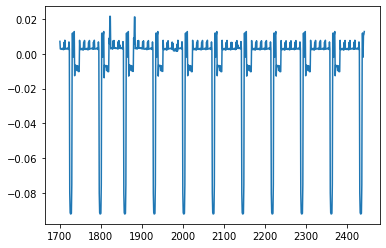

In [47]:
plt.figure()
plt.plot(curr.RF_results)
#plt.plot(curr.Residuals_pct_occupied_sarima)
plt.show()

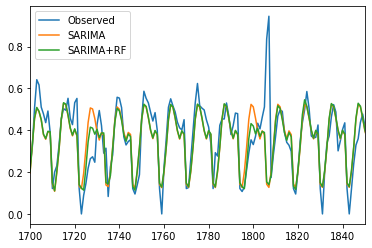

In [48]:
fig, ax = plt.subplots()
ax.plot(curr['PercentOccupied'], label='Observed')

ax.plot(curr['SARIMA_Preds'], label='SARIMA')
ax.plot(curr['SARIMA_Plus_RF'], label='SARIMA+RF')
ax.legend()
ax.set_xlim(1700,1850)
plt.show()

In [49]:
arima3_results = pd.read_pickle('arima_results3/arima_results.pkl')
arima3_results.head()

,ArimaSmapeErrors,GBMSmapeErrors,TrainingSetLength,ArimaRMSEs,ModelOrder,TestVals,ArimaPreds,GBMPreds,NonSeasonal,Seasonal,p,d,q,P,D,Q,m,ArimaSmapeErrors_org
SourceElementKey,,,,,,,,,,,,,,,,,,
1001,16.627545,20.289312,1710,0.114824,"((0, 0, 0), (4, 0, 4, 12))",OccupancyDateTime 2019-06-20 18:00:00 0.121...,"[0.14342548005930653, 0.10816144442303331, 0.1...","[0.3234989236773411, 0.3234989236773411, 0.323...","(0, 0, 0)","(4, 0, 4, 12)",0,0,0,4,0,4,12,30.826775
1002,15.389877,20.315699,1710,0.105749,"((1, 0, 1), (4, 0, 4, 12))",OccupancyDateTime 2019-06-20 18:00:00 0.121...,"[0.11628836533130664, 0.09052023912813748, 0.1...","[0.3084913086619947, 0.3084913086619947, 0.308...","(1, 0, 1)","(4, 0, 4, 12)",1,0,1,4,0,4,12,30.916092
1006,10.864261,15.851796,1713,0.077679,"((1, 0, 3), (4, 0, 3, 12))",OccupancyDateTime 2019-06-20 17:00:00 0.264...,"[0.22858474416047397, 0.20060697808277217, 0.1...","[0.2739473230825814, 0.2739473230825814, 0.273...","(1, 0, 3)","(4, 0, 3, 12)",1,0,3,4,0,3,12,23.858915
1009,9.721457,16.294263,1713,0.092156,"((2, 0, 2), (2, 0, 2, 12))",OccupancyDateTime 2019-06-20 17:00:00 0.425...,"[0.49878056740916354, 0.5439141832878749, 0.42...","[0.39008973556375254, 0.39008973556375254, 0.3...","(2, 0, 2)","(2, 0, 2, 12)",2,0,2,2,0,2,12,35.346899
1010,8.769851,15.738368,1713,0.074922,"((1, 0, 0), (5, 0, 2, 12))",OccupancyDateTime 2019-06-20 17:00:00 0.386...,"[0.4675529010924123, 0.5045618431812267, 0.397...","[0.3773656404765852, 0.3773656404765852, 0.377...","(1, 0, 0)","(5, 0, 2, 12)",1,0,0,5,0,2,12,19.594693


In [50]:
arima3_results['ArimaPlusRFSmapeErrors'] = np.nan
for block in arima3_results.index.values:
    mask = (merged['SourceElementKey'] == block) & (merged['OccupancyDateTime'] > (test_date))
    curr = merged[mask]
    if len(curr.SARIMA_Plus_RF) > 0:
    
        arima_rf_smape = smape_error(curr.SARIMA_Plus_RF, curr.PercentOccupied)
        arima3_results.at[block, 'ArimaPlusRFSmapeErrors'] = arima_rf_smape
    else:
        print(block)

In [51]:
arima3_results[['ArimaPlusRFSmapeErrors', 'ArimaSmapeErrors', 'GBMSmapeErrors']].dropna(axis=0).mean()

ArimaPlusRFSmapeErrors    10.148945
ArimaSmapeErrors          10.442124
GBMSmapeErrors            15.499295
dtype: float64

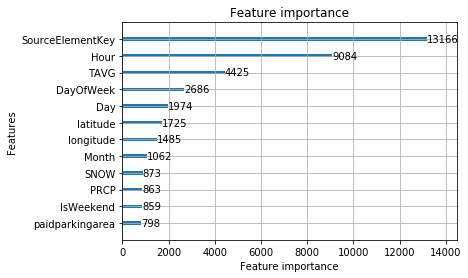

In [52]:
lgb.plot_importance(gbm_rf)

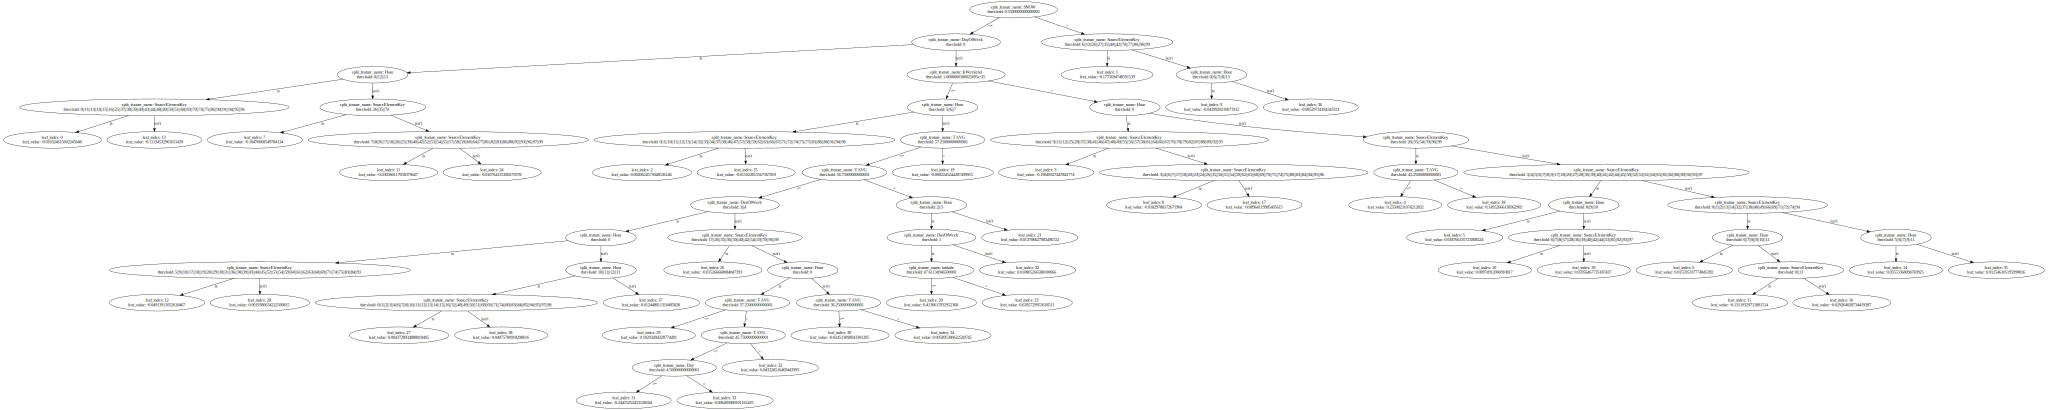

In [53]:
lgb.create_tree_digraph(gbm_rf)